In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

sns.set_context('talk')
sns.set_style("whitegrid")
sns.set_palette("colorblind")

import copy
from hendrics.fake import filter_for_deadtime
from stingray import Powerspectrum, Crossspectrum, AveragedPowerspectrum


import numpy as np
import scipy.stats
import scipy.special
import scipy.fftpack

from stingray.utils import rebin_data

np.random.seed(348172694)

from stingray import Lightcurve, Crossspectrum
from stingray.simulator.simulator import Simulator
from scipy.ndimage.filters import gaussian_filter1d

from scipy.interpolate import interp1d
from stingray.utils import rebin_data_log
from stingray.gti import bin_intervals_from_gtis
from hendrics.base import r_in, r_det
from fad_correction import *

from astropy.io.fits import Header
from simulations import *




## Real data - that's where we need to get real

First, we need to process all the data with the standard nustar pipeline, and run barycorr with the correct clock correction file to set the times to the Solary System barycenter.
Here, I put all the processed data in the directory `../data/`.

In [2]:
from hendrics.io import load_events, load_lcurve, load_pds, save_lcurve, save_pds
from stingray.gti import cross_two_gtis
from stingray import Powerspectrum, Crossspectrum, AveragedPowerspectrum, AveragedCrossspectrum

```
# Read all events into HENDRICS format
> HENreadevents ../data/*.evt
# Light curve with bin time 1/1024 s
> HENlcurve ../data/*_ev.nc -b -10
```

In [3]:
import glob
allfiles = glob.glob('../data/nu*_lc.nc')
allfiles = sorted(allfiles)
allfiles = list(zip(allfiles[:-1:2], allfiles[1::2]))
allfiles

[('../data/nu00001011002A01_cl_C_nustar_fpma_lc.nc',
  '../data/nu00001011002B01_cl_C_nustar_fpmb_lc.nc'),
 ('../data/nu10002013003A01_cl_C_nustar_fpma_lc.nc',
  '../data/nu10002013003B01_cl_C_nustar_fpmb_lc.nc'),
 ('../data/nu10013029001A01_cl_C_nustar_fpma_lc.nc',
  '../data/nu10013029001B01_cl_C_nustar_fpmb_lc.nc'),
 ('../data/nu10202002002A01_cl_C_nustar_fpma_lc.nc',
  '../data/nu10202002002B01_cl_C_nustar_fpmb_lc.nc')]

In [4]:
labels = []
for f1, f2 in allfiles:
    lc1 = load_lcurve(f1)
    header = Header.fromstring(lc1.header)
    label = header['OBJECT']
    labels.append(label)

    if os.path.exists(label + '.png'):
        continue

    lc2 = load_lcurve(f2)

    # Use common GTIs!
    gti = cross_two_gtis(lc1.gti, lc2.gti)
    lc1.gti = gti
    lc2.gti = gti
    lc1._apply_gtis()
    lc2._apply_gtis()
    
    calculate_fad_and_save_all_spectra(lc1, lc2, file_label=label, 
                                       segment_size=256, norm='leahy')
    

In [7]:
def plot_fad_results(file_label, rebin_factor = 1.):
    pdstot_norm_reb = load_rebinned(file_label + 'pdstot_norm.nc', rebin_factor)
    pds1_dt_reb = load_rebinned(file_label + 'pds1_dt.nc', rebin_factor)
    plt.figure(figsize=(10, 5))
    plt.plot(pdstot_norm_reb.freq, pdstot_norm_reb.power, color='k', 
             drawstyle='steps-mid', label='PDS, FAD-corrected')
    plt.plot(pds1_dt_reb.freq, pds1_dt_reb.power, color='grey', 
             drawstyle='steps-mid', label='PDS')
    plt.ylim([np.min(pds1_dt_reb.power), 
              np.max(pds1_dt_reb.power[pds1_dt_reb.freq > 10])])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power (Leahy)')
    plt.title(file_label)
    plt.legend()
    plt.savefig(file_label + '.png')


<IPython.core.display.Javascript object>


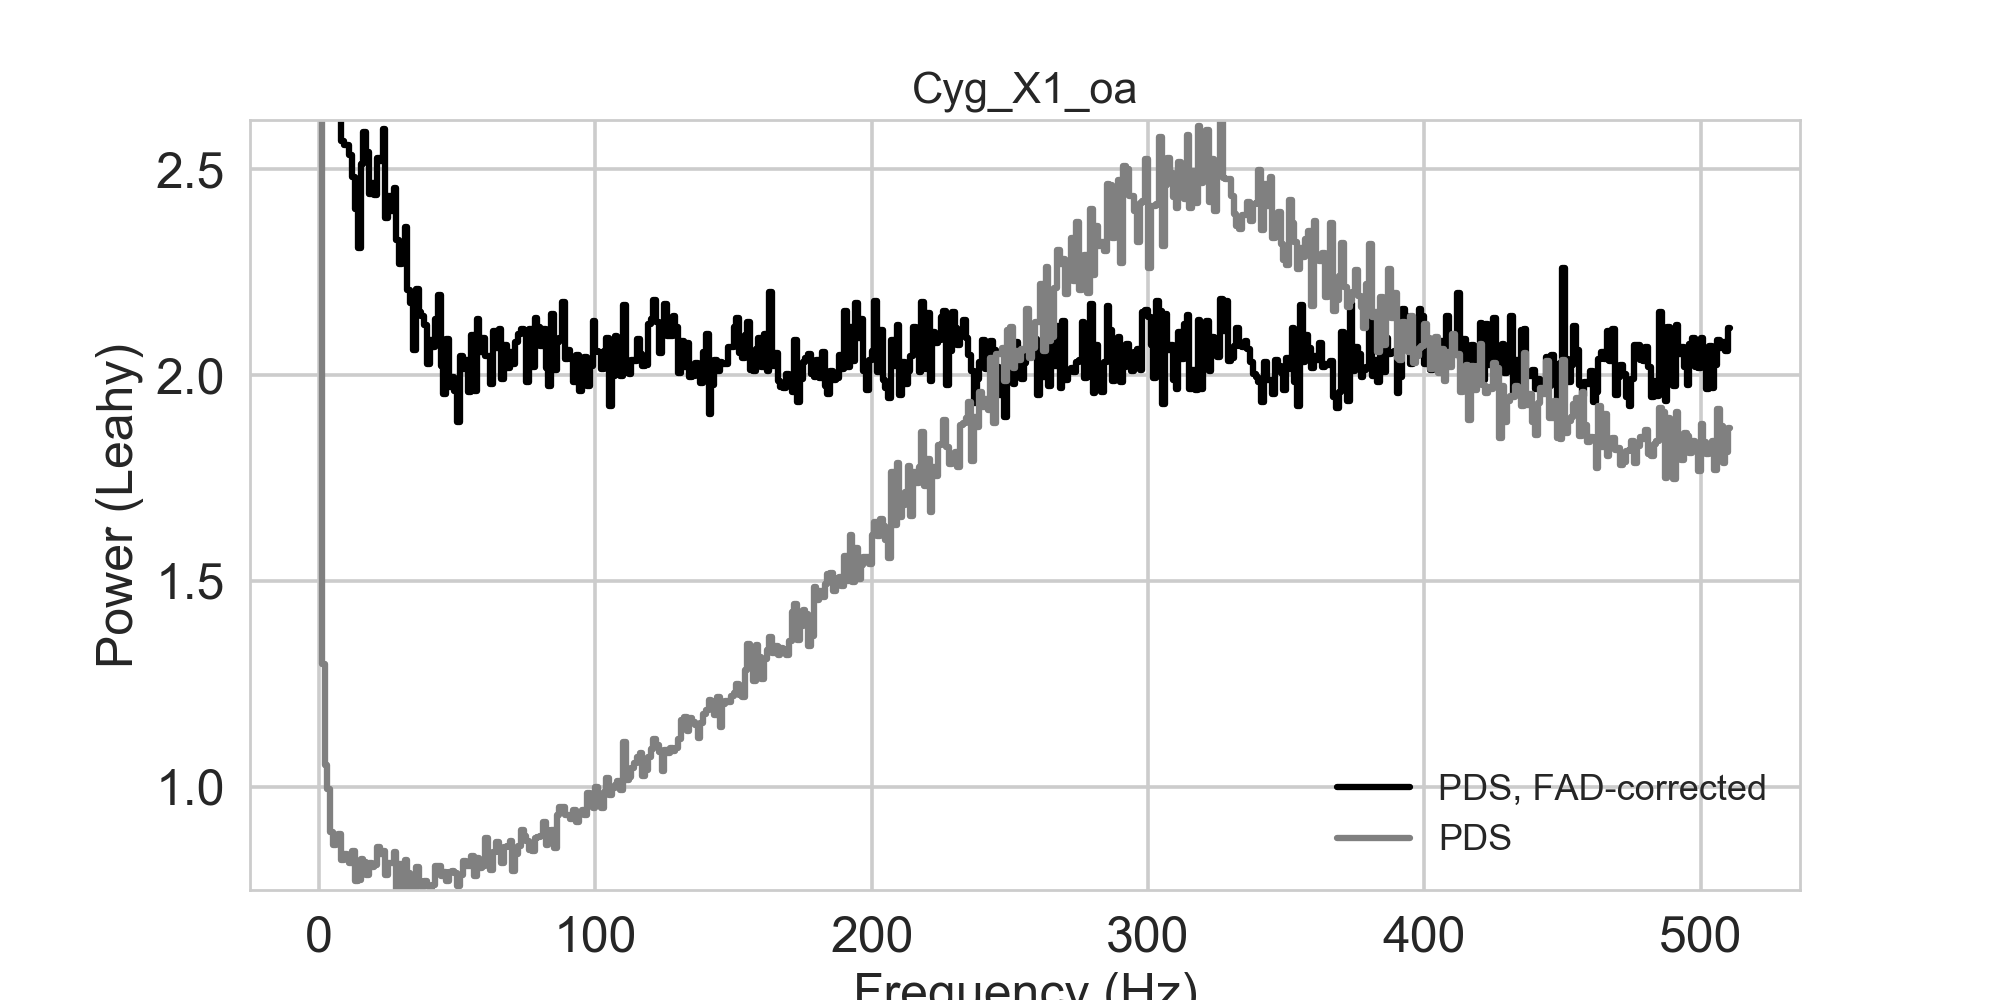

<IPython.core.display.Javascript object>


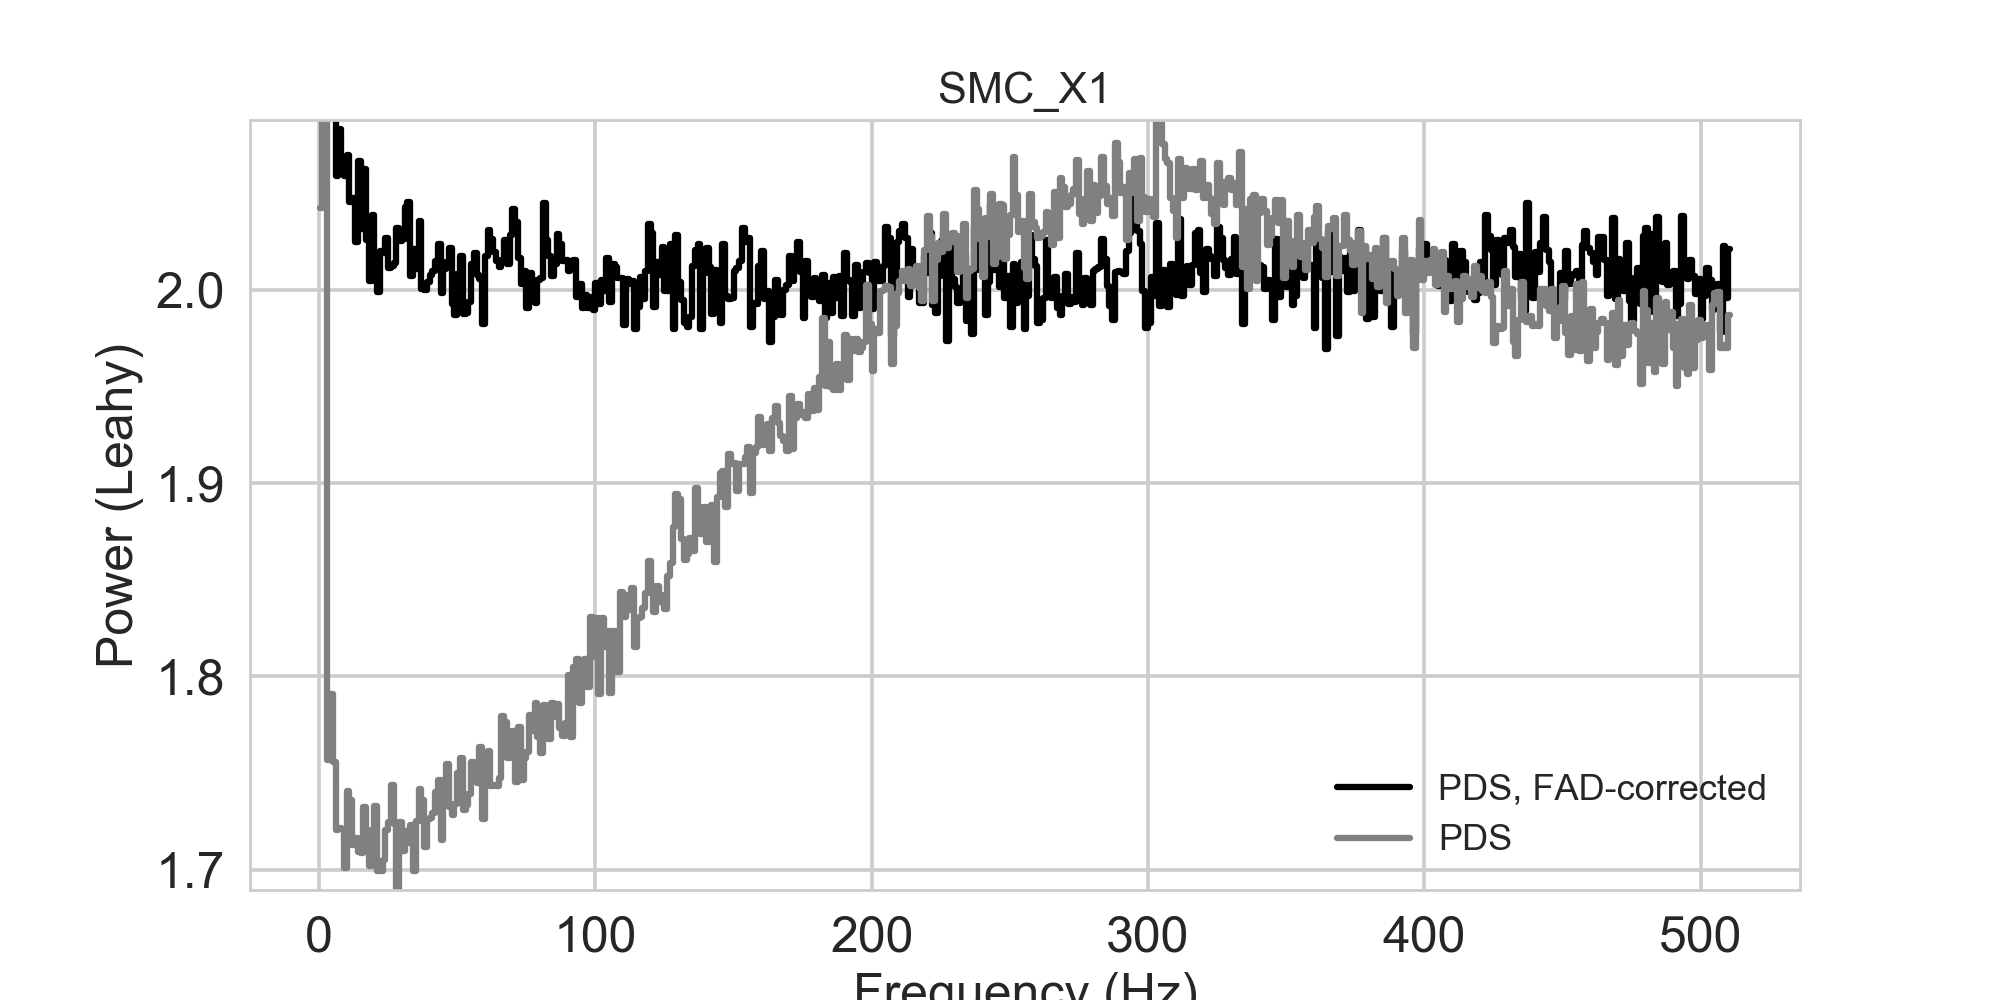

<IPython.core.display.Javascript object>


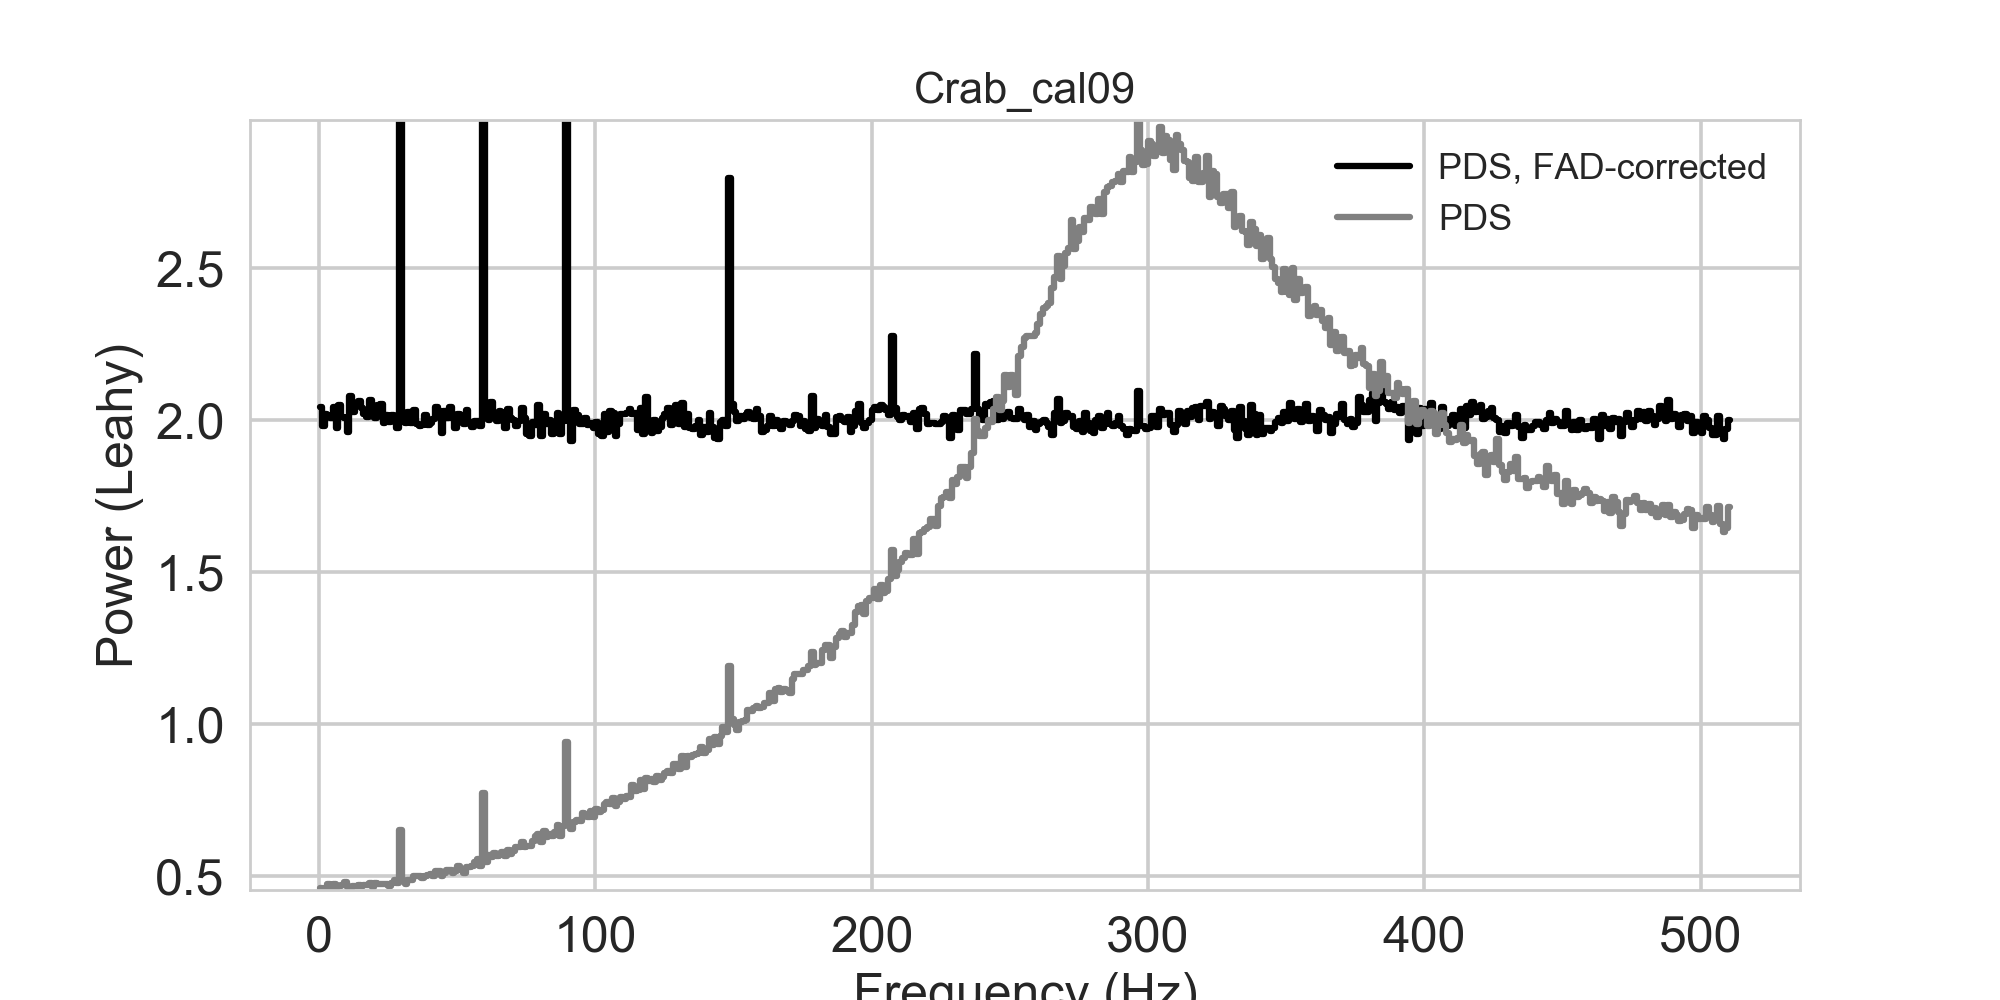

<IPython.core.display.Javascript object>


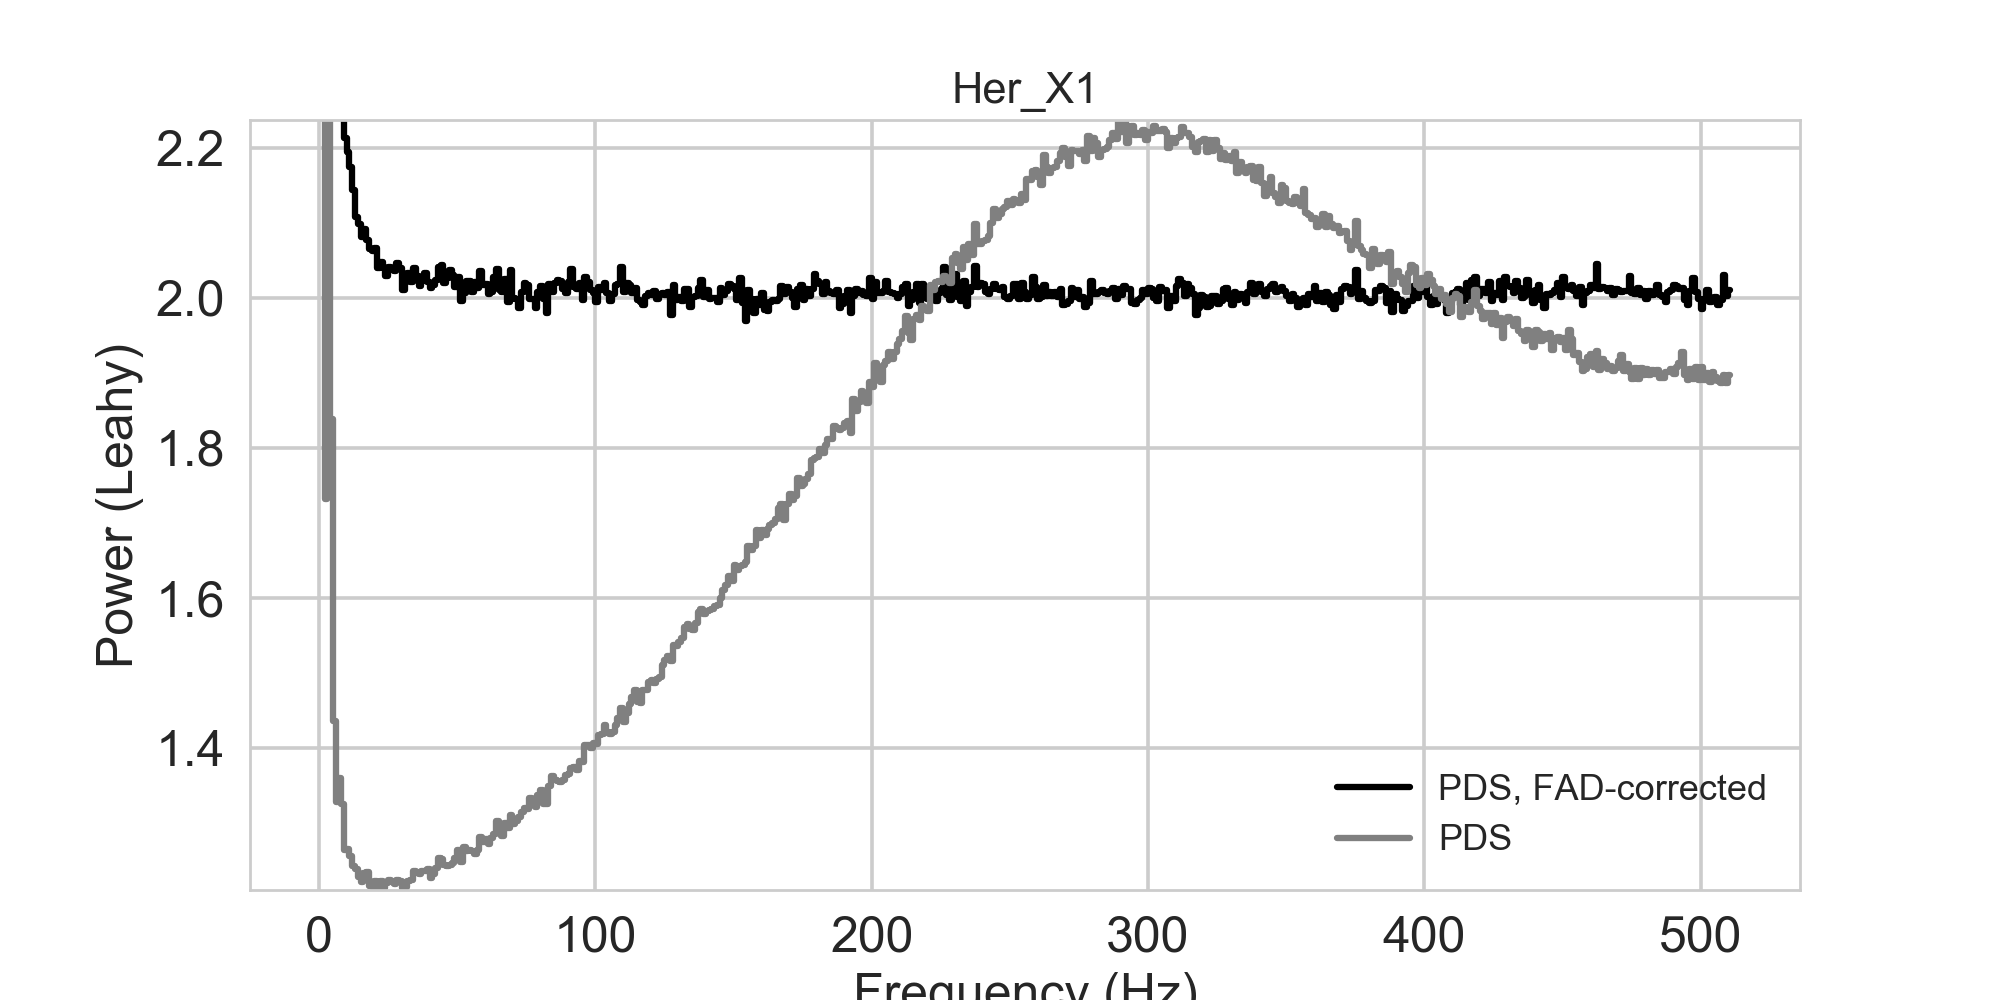

In [8]:
for l in labels:
    plot_fad_results(l)